<a href="https://colab.research.google.com/github/OlegV12/Neural/blob/Lesson_1/Lesson_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
'''
Исходный код к уроку 1.
Построение двухслойной нейронный сети для классификации цветков ириса
'''
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

In [99]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [100]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive
# iris = load_iris()

In [101]:
# data1 = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
#                      columns= iris['feature_names'] + ['target'])

In [102]:
# data1

## Обратное распространение ошибки и градиентный спуск

Давайте прежде чем начнем разбирать обратное распространение и градиентный спуск, скажем несколько слов о тех типах архитектур нейронной сети, которые будут использованы в данном уроке. Это простые нейронные сети. С точки зрения архитектуры их можно отнести к полносвязным нейронным сетям так как все нейроны связаны между собой. С другой стороны их можно отнести к нейронным сетям прямого распространения(feed forward). Сети прямого распространения подразумевает распространения сигналы от вход к выходу, в отличии от реккурентных нейронных сетей где во внутренних слоях сигналы могут ходить по циклу. О плюсах и минусах сетей полносвязных мы поговорим в уроке посвященном Сверточным нейронным сетям, поскольку данные нейронные сети отошли от этого подхода и нам нужно будет выяснить почему.

После того как на выходе нейронной сети мы получили определенное цифровое значение нам нужно сравнить его с искомым. Мы можем посчитать насколько в количественом выражение ошиблась нейросеть. Задача обратного распространения ошибки пройтись от выхода ко входу и скорректировать веса нейронов. Это процесс происходит множество раз в процесс обучения.

Можно сказать что процесс обучения нейронной сети это попытка оптимизировать веса 
нейронной сети до тех пор пока не будет достигнута минимальная степень ошибки. Для этого хорошо подходит такой алгоритм как градиентный спуск. Суть данного метода заключается в том, чтобы искать такие числовые параметры при которых значение ошибки достигнет нуля. Градиентным он называется потому что это процесс пошаговый, требующий одно вычисление за другим. Спуском он называется потому что значение ошибки должно быть как можно меньше.

Обратите внимание на следующий график из него видно, что есть определенное число по шкале весов которому соотсвествует минимальное значение по шкале Error. Это число и нужно находить в процессе обучения нейронных сетей.

Давайте попробуем реализовать программного градиентный спуск, чтобы лучше понять как он работает.

Метод обратного распрасранения (backpropogation) самый популярный способ обучения нейронных сетей, однако у него есть несколько альтернатив - Метод упругого распространения (Resilient propagation или Rprop)  и генетический алгоритм (Genetic Algorithm). Rprop для корректировки весов и смещений использует знак градиента, а не его значение, а генетический алгоритм для задач оптимизации и моделирования использует случайный подбор.


## Пример построения  двухслойной нейронной сети на numpy

In [103]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return (x)*(1 - (x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

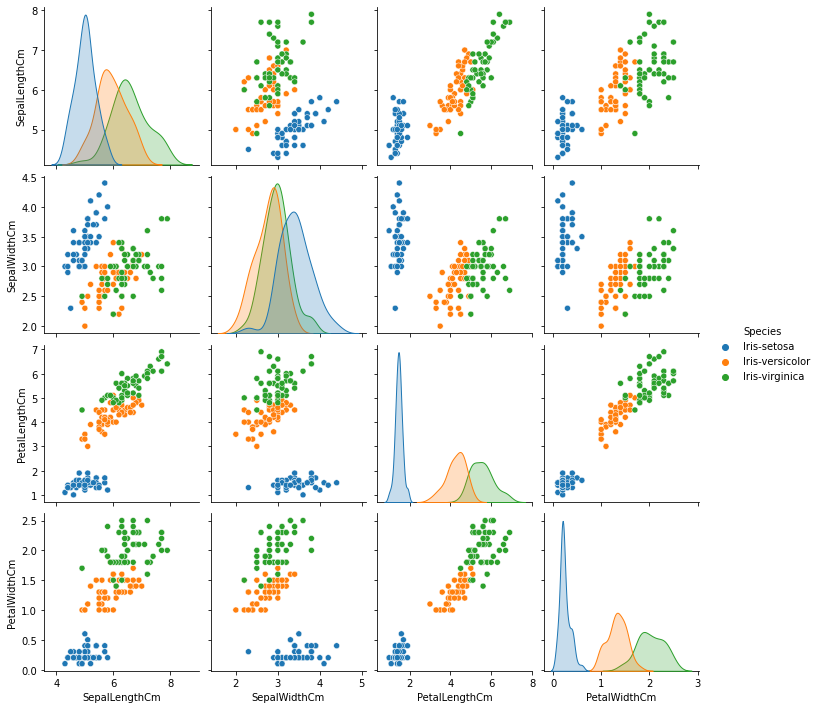

In [104]:

### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("/gdrive/MyDrive/Colab Notebooks/Neural Net/Iris.csv")
# print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
# plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
#x = normalize(x.as_matrix())
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
#y = y.as_matrix()
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [105]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [106]:
### Шаг 3. Обученние нейронной сети

class Neural_net:

    def __init__(self, neuron_numb=5, epoch=3000, learning_rate = 0.005):
        self.neuron_numb = neuron_numb
        self.epoch = epoch
        self.w0 = 2*np.random.random((4, neuron_numb)) - 1
        self.w1 = 2*np.random.random((neuron_numb, 3)) - 1
        self.learning_rate = learning_rate
        self.errors = []
        self.error = 0
        self.accuracy = 0 

    def learn(self, X_train, y_train):

        # процесс обучения
        for i in range(self.epoch):

            # прямое распространение(feed forward)
            self.layer0 = X_train
            self.layer1 = sigmoid(np.dot(self.layer0, self.w0))
            self.layer2 = sigmoid(np.dot(self.layer1, self.w1))

            # обратное распространение(back propagation) с использованием градиентного спуска
            self.layer2_error = y_train - self.layer2 # производная функции потерь = производная квадратичных потерь 
            self.layer2_delta = self.layer2_error * sigmoid_deriv(self.layer2)
            
            self.layer1_error = self.layer2_delta.dot(self.w1.T)
            self.layer1_delta = self.layer1_error * sigmoid_deriv(self.layer1)
            # коррекция
            self.w1 += self.layer1.T.dot(self.layer2_delta) * self.learning_rate
            self.w0 += self.layer0.T.dot(self.layer1_delta) * self.learning_rate
            # метрика модели
            self.error = np.mean(np.abs(self.layer2_error))
            self.errors.append(self.error)
            self.accuracy = (1 - self.error) * 100

        return self



    def predict(self, X_test):
        self.layer0_t = X_test
        self.layer1_t = sigmoid(np.dot(self.layer0_t, self.w0))
        self.layer2_t = sigmoid(np.dot(self.layer1_t, self.w1))
        return self.layer2_t

In [107]:
model = Neural_net()

model.learn(X_train, y_train)

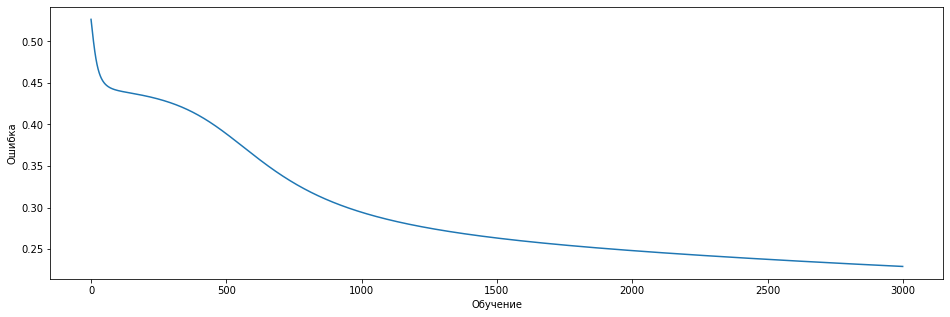

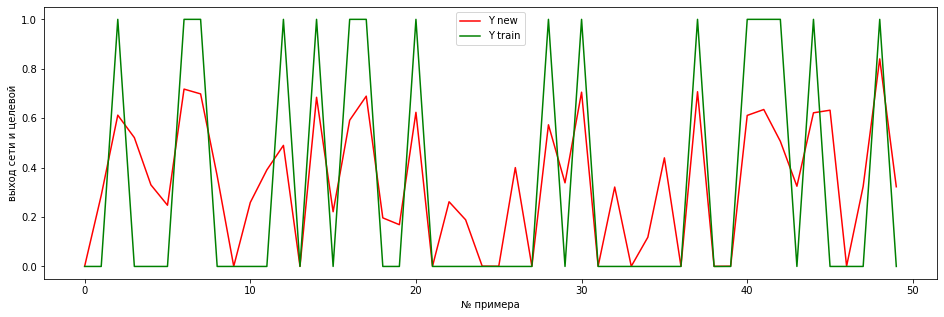

Аккуратность нейронной сети 77.09%


In [108]:
### Шаг 4. Демонстрация полученных результатов
# черчение диаграммы точности в зависимости от обучения
plt.figure(figsize = (16,5))
plt.plot(model.errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() # расскоментируйте, чтобы посмотреть 

N = 50
plt.figure(figsize = (16,5))
plt.plot(model.layer2[:N,1], 'r',label = 'Y new')
plt.plot(y_train[:N,1],'g', label = 'Y train')
plt.xlabel('№ примера')
plt.ylabel('выход сети и целевой')
plt.legend( )
plt.show() # расскоментируйте, чтобы посмотреть 
        
print("Аккуратность нейронной сети " + str(round(model.accuracy,2)) + "%")



In [109]:
model.w1

array([[-4.31170217,  3.03786544,  1.20616898],
       [-0.89854678,  0.07799668, -1.10344056],
       [-3.00005581,  2.51419401,  0.37715232],
       [ 0.82927472, -3.77187076, -0.43468777],
       [ 4.9308053 , -6.15152908, -0.96080306]])

In [110]:
model.w1

array([[-4.31170217,  3.03786544,  1.20616898],
       [-0.89854678,  0.07799668, -1.10344056],
       [-3.00005581,  2.51419401,  0.37715232],
       [ 0.82927472, -3.77187076, -0.43468777],
       [ 4.9308053 , -6.15152908, -0.96080306]])

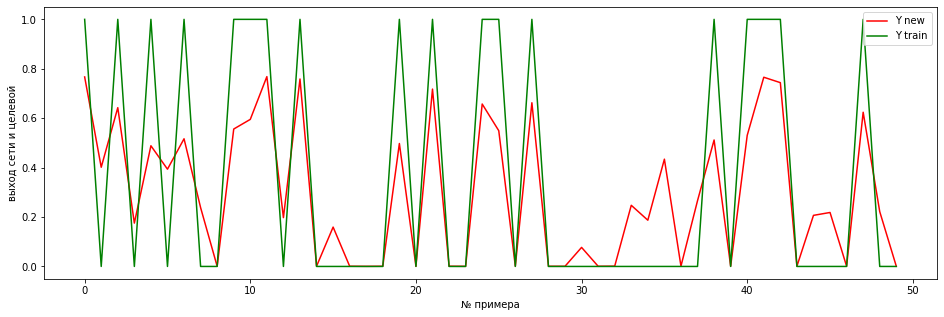

Аккуратность нейронной сети на тесте 78.01%


In [111]:
# прямое распространение(feed forward)
# layer0_t = X_test
# layer1_t = sigmoid(np.dot(layer0_t, w0))
# layer2_t = sigmoid(np.dot(layer1_t, w1))

preds = model.predict(X_test)
layer2_error_t = y_test - preds
    
    
N = 50
plt.figure(figsize = (16,5))
plt.plot(preds[:N,1], 'r',label = 'Y new')
plt.plot(y_test[:N,1],'g', label = 'Y train')
plt.xlabel('№ примера')
plt.ylabel('выход сети и целевой')
plt.legend( )
plt.show() # расскоментируйте, чтобы посмотреть

# метрика модели
error_t = np.mean(np.abs(layer2_error_t))
accuracy_t = (1 - error_t) * 100
print("Аккуратность нейронной сети на тесте " + str(round(accuracy_t,2)) + "%")

В этом уроке мы с вами рассматривали как сделать простые нейронные сети без использования специальных фреймворков и библиотек для этого. В следующих уроках мы с вами познакомимся как делать нейронные сети с помощью Keras и TensorFlow.

## Домашнее задание

1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность (число нейронов, число эпох , можно изменять число слоев).
2. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

Мы разобрались с основами обучения нейронных сетей и получили некоторое представление об архитектурах простых нейронных сетей. Давайте попробуем закрепить эти знания на практике. Кроме того на примере который будет изложен ниже возможно проясняться какие-либо оставшиеся вопросы.

В данном примере мы сделаем нейронную сеть которая будет отличать различные виды ириса между собой. Надо полагать данный датасет вам уже знаком. Логика работы этого кода будет такой же как и в первом разобранном примере, но только все компоненты этого кода будут несколько усложнены.

## Дополнительные материалы

<ol>
    <li>https://medium.com/topic/machine-learning</li>
</ol>

## Используемая литература 

Для подготовки данного методического пособия были использованы следующие ресурсы:
<ol>
    <li>Глубокое обучение — Николенко С. И., Кадурин 2018</li>
    <li>Шакла Н. — Машинное обучение и TensorFlow 2019</li>
    <li>Asifullah Khan, Anabia Sohail, Umme Zahoora, Aqsa Saeed Qureshi - A Survey of the Recent Architectures of Deep Convolutional Neural Networks 2019</li>
    <li>A direct adaptive method for faster backpropagation learning: the RPROP algorithm - Neural Networks, 1993</li>
    <li>Википедия</li>
    
</ol>

In [112]:
pip install hyperopt

In [113]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [114]:
space = {
    "epoch": hp.choice("epoch", [3000, 5000, 8000]),
    "neuron_numb": hp.choice("neuron_numb", [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]),
    "learning_rate": hp.uniform("learning_rate", 0.0001, 0.1,),
}

In [115]:
def hyperparameter_tuning(params):
    clf = Neural_net(**params,)
    clf.learn(X_train, y_train)
    acc = (1 - np.mean(np.abs(y_test - clf.predict(X_test)))) * 100
    return {"loss": -acc, "status": STATUS_OK}

In [116]:
trials = Trials()

best = fmin(fn=hyperparameter_tuning,
    		space=space,
    		algo=tpe.suggest,
    		max_evals=50,
				trials=trials)

print(best)

100%|██████████| 50/50 [00:44<00:00,  1.13it/s, best loss: -94.60715110095681]
{'epoch': 2, 'learning_rate': 0.09479833069507451, 'neuron_numb': 8}


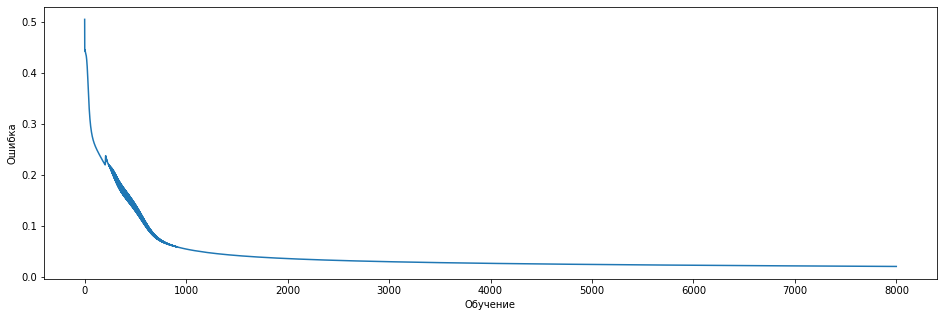

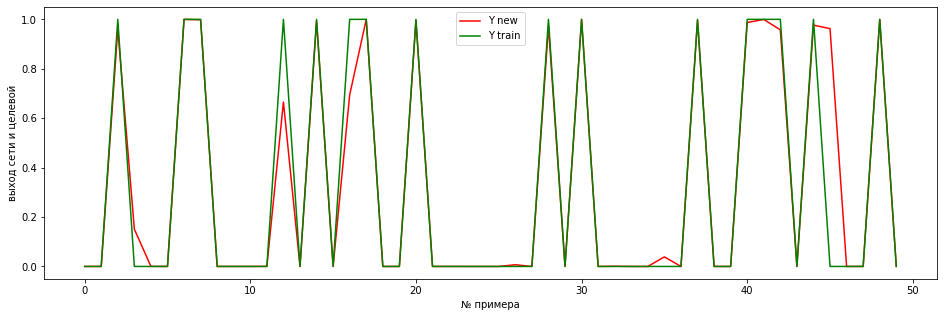

Аккуратность нейронной сети 97.9%


In [117]:
model = Neural_net(epoch=8000, neuron_numb=8, learning_rate=0.0999)

model.learn(X_train, y_train)

plt.figure(figsize = (16,5))
plt.plot(model.errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() # расскоментируйте, чтобы посмотреть 

N = 50
plt.figure(figsize = (16,5))
plt.plot(model.layer2[:N,1], 'r',label = 'Y new')
plt.plot(y_train[:N,1],'g', label = 'Y train')
plt.xlabel('№ примера')
plt.ylabel('выход сети и целевой')
plt.legend( )
plt.show() # расскоментируйте, чтобы посмотреть 
        
print("Аккуратность нейронной сети " + str(round(model.accuracy,2)) + "%")


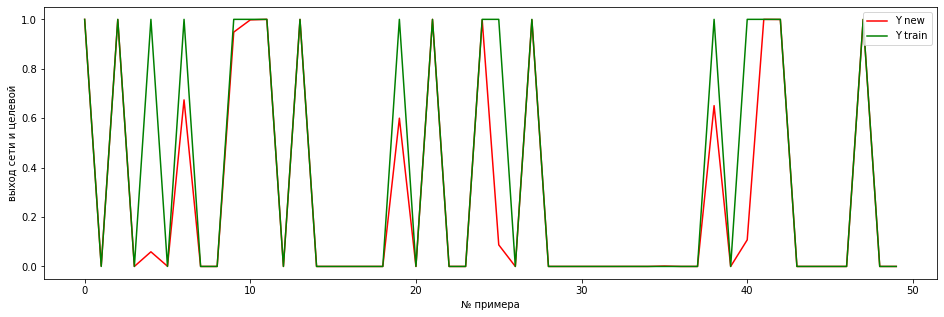

Аккуратность нейронной сети на тесте 94.62%


In [118]:
preds = model.predict(X_test)
layer2_error_t = y_test - preds
    
    
N = 50
plt.figure(figsize = (16,5))
plt.plot(preds[:N,1], 'r',label = 'Y new')
plt.plot(y_test[:N,1],'g', label = 'Y train')
plt.xlabel('№ примера')
plt.ylabel('выход сети и целевой')
plt.legend( )
plt.show() # расскоментируйте, чтобы посмотреть

# метрика модели
error_t = np.mean(np.abs(layer2_error_t))
accuracy_t = (1 - error_t) * 100
print("Аккуратность нейронной сети на тесте " + str(round(accuracy_t,2)) + "%")

К ухудшению точности приведет снижение количества эпох обучения менее 1000, неверно подобранный learning rate также приводит к снижению качества модели. 

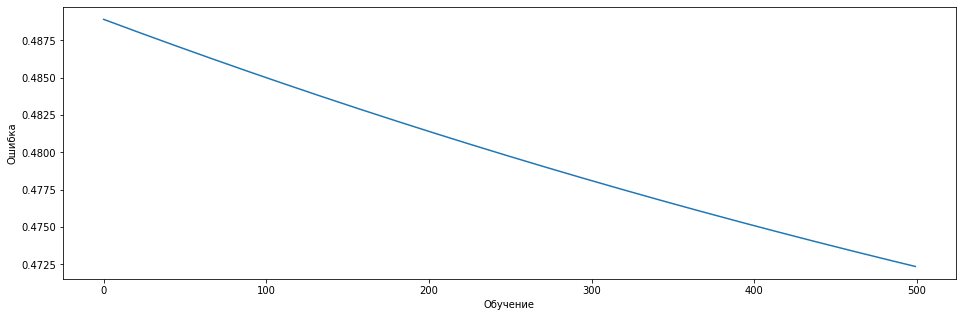

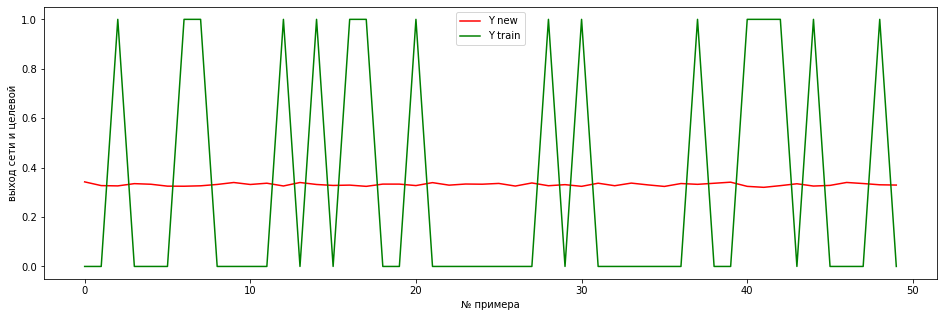

Аккуратность нейронной сети 52.76%


In [119]:
model = Neural_net(epoch=500, neuron_numb=8, learning_rate=0.0001)

model.learn(X_train, y_train)

plt.figure(figsize = (16,5))
plt.plot(model.errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() # расскоментируйте, чтобы посмотреть 

N = 50
plt.figure(figsize = (16,5))
plt.plot(model.layer2[:N,1], 'r',label = 'Y new')
plt.plot(y_train[:N,1],'g', label = 'Y train')
plt.xlabel('№ примера')
plt.ylabel('выход сети и целевой')
plt.legend( )
plt.show() # расскоментируйте, чтобы посмотреть 
        
print("Аккуратность нейронной сети " + str(round(model.accuracy,2)) + "%")